In [46]:
import numpy as np
import nltk
import pandas as pd
from pathlib import Path

from nltk.tag.hmm import HiddenMarkovModelTagger
from nltk import FreqDist
from collections import Counter

# === Importar nuestro modelo y funciones del proyecto ===
from model.hmm import HMM
from main import get_data, per_tag_accuracy, accuracy as hmm_accuracy

FIG_DIR = Path("conclusiones/figuras")
FIG_DIR.mkdir(parents=True, exist_ok=True)


The function below:

- reads the CSV file  
- splits the *text* field into words  
- splits the *tags* field into POS labels  
- checks that words and tags match in length  
- returns a list of `(word, tag)` sequences

In [47]:
def load_ud_csv(path):
    df = pd.read_csv(path, encoding="latin1")
    sentences = []
    for _, row in df.iterrows():
        words = row["text"].split()
        tags = row["tags"].split()
        assert len(words) == len(tags)
        sentences.append(list(zip(words, tags)))
    return sentences

In [48]:
train = load_ud_csv("datasets/ud_basque/ud_basque_train.csv")
dev   = load_ud_csv("datasets/ud_basque/ud_basque_dev.csv")
test  = load_ud_csv("datasets/ud_basque/ud_basque_test.csv")

train_sentences, train_tags = get_data("datasets/ud_basque/ud_basque_train.csv")
dev_sentences,   dev_tags   = get_data("datasets/ud_basque/ud_basque_dev.csv")
test_sentences,  test_tags  = get_data("datasets/ud_basque/ud_basque_test.csv")

print(f"# sentences in train: {len(train_sentences)}")
print(f"# sentences in dev:   {len(dev_sentences)}")
print(f"# sentences in test:  {len(test_sentences)}")

# sentences in train: 5396
# sentences in dev:   1798
# sentences in test:  1799


In [49]:
# === CARGA DE DATOS: CATALÁN ===
train_ca = load_ud_csv("datasets/ud_catalan/ud_catalan_train.csv")
dev_ca   = load_ud_csv("datasets/ud_catalan/ud_catalan_dev.csv")
test_ca  = load_ud_csv("datasets/ud_catalan/ud_catalan_test.csv")

train_sentences_ca, train_tags_ca = get_data("datasets/ud_catalan/ud_catalan_train.csv")
dev_sentences_ca,   dev_tags_ca   = get_data("datasets/ud_catalan/ud_catalan_dev.csv")
test_sentences_ca,  test_tags_ca  = get_data("datasets/ud_catalan/ud_catalan_test.csv")

print(f"# [CAT] sentences in train: {len(train_sentences_ca)}")
print(f"# [CAT] sentences in dev:   {len(dev_sentences_ca)}")
print(f"# [CAT] sentences in test:  {len(test_sentences_ca)}")


# [CAT] sentences in train: 13123
# [CAT] sentences in dev:   1709
# [CAT] sentences in test:  1846


In [50]:
print("Ejemplo de oración en el train:")
print(train[0])

Ejemplo de oración en el train:
[('Gero', 'ADV'), (',', 'PUNCT'), ('lortutako', 'VERB'), ('masa', 'NOUN'), ('molde', 'NOUN'), ('batean', 'NUM'), ('jarri', 'VERB'), ('.', 'PUNCT')]


In [51]:
print("Nº oraciones entreno:", len(train))
print("Nº oraciones dev:", len(dev))
print("Nº oraciones test:", len(test))

Nº oraciones entreno: 5396
Nº oraciones dev: 1798
Nº oraciones test: 1799


In [52]:
all_tags = [tag for sent in train for (_, tag) in sent]
tagset = set(all_tags)
print("Tags encontrados:", tagset)
print("Número total:", len(tagset))

Tags encontrados: {'PUNCT', 'CCONJ', 'DET', 'ADP', 'ADJ', 'AUX', 'X', 'NOUN', 'INTJ', 'ADV', 'PROPN', 'PART', 'NUM', 'SYM', 'VERB', 'PRON', 'SCONJ'}
Número total: 17


Tags encontrados (CAT): {'PUNCT', 'CCONJ', 'DET', 'ADP', 'AUX', 'ADJ', 'NOUN', 'INTJ', 'PROPN', 'ADV', 'PART', 'NUM', 'SYM', 'VERB', 'PRON', 'SCONJ'}
Número total (CAT): 16


<Axes: title={'center': 'Distribución de tags UD (Catalán)'}, xlabel='Samples', ylabel='Counts'>

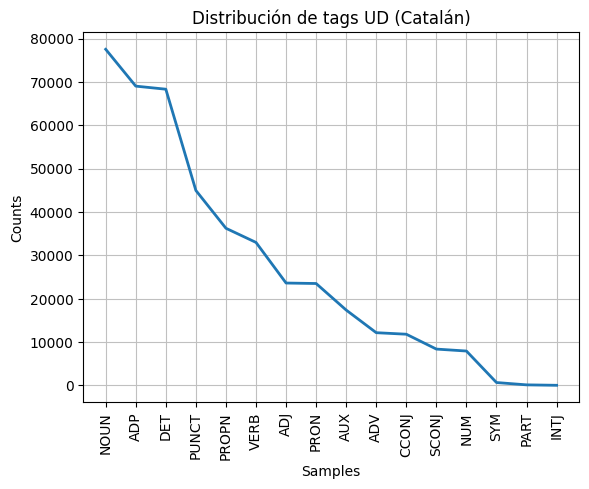

In [53]:
# === Distribución de tags para CATALÁN ===
all_tags_ca = [tag for sent in train_ca for (_, tag) in sent]
tagset_ca = set(all_tags_ca)
print("Tags encontrados (CAT):", tagset_ca)
print("Número total (CAT):", len(tagset_ca))

freq_ca = FreqDist(all_tags_ca)
freq_ca.plot(30, title="Distribución de tags UD (Catalán)")


Here we compute the frequency of each POS tag in the training set.
This is directly related to the theory discussed in class:

- HMMs estimate transition and emission probabilities from tag frequencies
- Frequent tags contribute more to probability estimates
- Rare tags are more affected by data sparsity

The plotted distribution helps visualize which tags dominate the corpus and anticipate challenges during training.

<Axes: title={'center': 'Distribución de tags UD (Euskera)'}, xlabel='Samples', ylabel='Counts'>

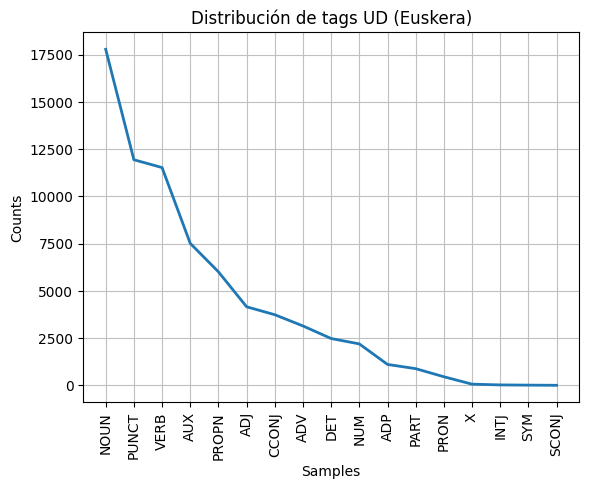

In [54]:
freq = FreqDist(all_tags)
freq.plot(30, title="Distribución de tags UD (Euskera)")

A Hidden Markov Model represents POS tagging through the joint probability:

\[
P(X, Y) = \prod_{i=1}^{n} P(y_i \mid y_{i-1}) \cdot P(x_i \mid y_i)
\]

Where:

- \(X = (x_1, x_2, \dots, x_n)\) are the observed words  
- \(Y = (y_1, y_2, \dots, y_n)\) are the hidden POS tags  
- \(P(y_i \mid y_{i-1})\) is the **transition probability**  
- \(P(x_i \mid y_i)\) is the **emission probability**  
- \(P(y_1)\) is the **initial state distribution**

The training procedure uses *Maximum Likelihood Estimation (MLE)* based on counting:

- tag transitions  
- tag→word emissions  
- initial tags at the start of sentences

`HiddenMarkovModelTagger.train()` automatically computes all these estimates from the training data.


In [55]:
# === HMM NLTK PARA EUSKERA ===
tagger_eu = HiddenMarkovModelTagger.train(train)

# === HMM NLTK PARA CATALÁN ===
tagger_ca = HiddenMarkovModelTagger.train(train_ca)

# === NUESTRO HMM PARA EUSKERA ===
hmm_eu = HMM()
hmm_eu.train(train_sentences=train_sentences, train_tags=train_tags)

# === NUESTRO HMM PARA CATALÁN ===
hmm_ca = HMM()
hmm_ca.train(train_sentences=train_sentences_ca, train_tags=train_tags_ca)


We evaluate the model using **token-level accuracy**, defined as:

\[
\text{accuracy} = 
\frac{\text{number of correctly predicted tags}}
{\text{total number of tags}}
\]

In [56]:
# ==== Accuracy del HMM de NLTK (EUSKERA) ====
acc_train_nltk_eu = tagger_eu.accuracy(train)
acc_dev_nltk_eu   = tagger_eu.accuracy(dev)
acc_test_nltk_eu  = tagger_eu.accuracy(test)

print(f"[NLTK HMM EU] Accuracy train: {acc_train_nltk_eu:.4f}")
print(f"[NLTK HMM EU] Accuracy dev:   {acc_dev_nltk_eu:.4f}")
print(f"[NLTK HMM EU] Accuracy test:  {acc_test_nltk_eu:.4f}")

# ==== Accuracy del HMM de NLTK (CATALÁN) ====
acc_train_nltk_ca = tagger_ca.accuracy(train_ca)
acc_dev_nltk_ca   = tagger_ca.accuracy(dev_ca)
acc_test_nltk_ca  = tagger_ca.accuracy(test_ca)

print(f"[NLTK HMM CA] Accuracy train: {acc_train_nltk_ca:.4f}")
print(f"[NLTK HMM CA] Accuracy dev:   {acc_dev_nltk_ca:.4f}")
print(f"[NLTK HMM CA] Accuracy test:  {acc_test_nltk_ca:.4f}")

# ==== Accuracy de nuestro HMM propio (EUSKERA) ====
acc_train_ours_eu = hmm_accuracy(hmm_eu, train_sentences,   train_tags)
acc_dev_ours_eu   = hmm_accuracy(hmm_eu, dev_sentences,     dev_tags)
acc_test_ours_eu  = hmm_accuracy(hmm_eu, test_sentences,    test_tags)

print(f"[Nuestro HMM EU] Accuracy train: {acc_train_ours_eu:.4f}")
print(f"[Nuestro HMM EU] Accuracy dev:   {acc_dev_ours_eu:.4f}")
print(f"[Nuestro HMM EU] Accuracy test:  {acc_test_ours_eu:.4f}")

# ==== Accuracy de nuestro HMM propio (CATALÁN) ====
acc_train_ours_ca = hmm_accuracy(hmm_ca, train_sentences_ca, train_tags_ca)
acc_dev_ours_ca   = hmm_accuracy(hmm_ca, dev_sentences_ca,   dev_tags_ca)
acc_test_ours_ca  = hmm_accuracy(hmm_ca, test_sentences_ca,  test_tags_ca)

print(f"[Nuestro HMM CA] Accuracy train: {acc_train_ours_ca:.4f}")
print(f"[Nuestro HMM CA] Accuracy dev:   {acc_dev_ours_ca:.4f}")
print(f"[Nuestro HMM CA] Accuracy test:  {acc_test_ours_ca:.4f}")


[NLTK HMM EU] Accuracy train: 0.9569
[NLTK HMM EU] Accuracy dev:   0.8258
[NLTK HMM EU] Accuracy test:  0.8189
[NLTK HMM CA] Accuracy train: 0.9703
[NLTK HMM CA] Accuracy dev:   0.9453
[NLTK HMM CA] Accuracy test:  0.9430
[Nuestro HMM EU] Accuracy train: 0.9693
[Nuestro HMM EU] Accuracy dev:   0.8622
[Nuestro HMM EU] Accuracy test:  0.8560
[Nuestro HMM CA] Accuracy train: 0.9761
[Nuestro HMM CA] Accuracy dev:   0.9477
[Nuestro HMM CA] Accuracy test:  0.9445


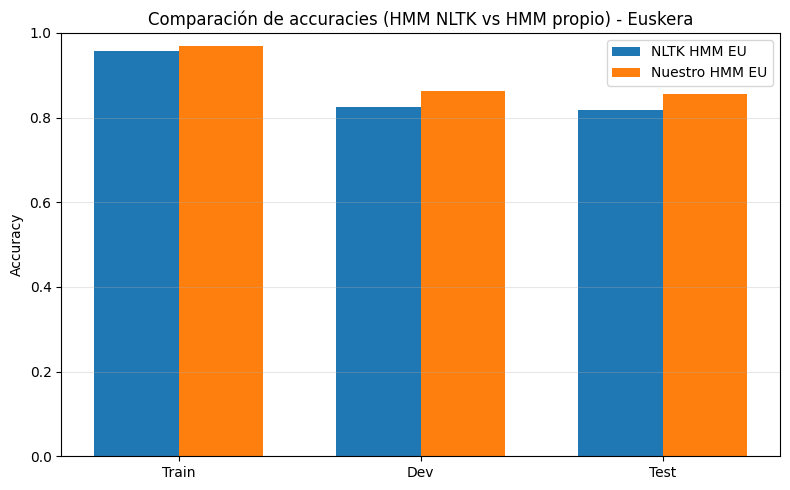

In [57]:
import matplotlib.pyplot as plt

models = ["Train", "Dev", "Test"]
nltk_acc_eu = [acc_train_nltk_eu, acc_dev_nltk_eu, acc_test_nltk_eu]
ours_acc_eu = [acc_train_ours_eu, acc_dev_ours_eu, acc_test_ours_eu]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, nltk_acc_eu, width, label="NLTK HMM EU")
plt.bar(x + width/2, ours_acc_eu, width, label="Nuestro HMM EU")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Comparación de accuracies (HMM NLTK vs HMM propio) - Euskera")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "hmm_accuracy_eu.png", dpi=300, bbox_inches="tight")
plt.show()




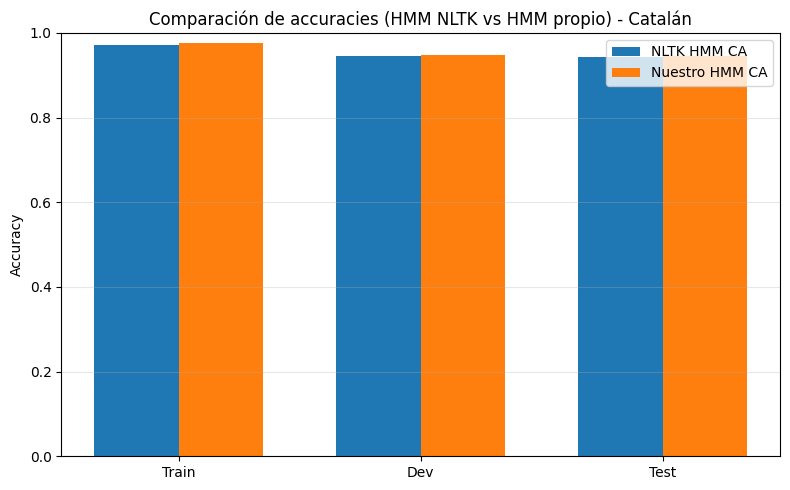

In [58]:
nltk_acc_ca = [acc_train_nltk_ca, acc_dev_nltk_ca, acc_test_nltk_ca]
ours_acc_ca = [acc_train_ours_ca, acc_dev_ours_ca, acc_test_ours_ca]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, nltk_acc_ca, width, label="NLTK HMM CA")
plt.bar(x + width/2, ours_acc_ca, width, label="Nuestro HMM CA")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Comparación de accuracies (HMM NLTK vs HMM propio) - Catalán")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "hmm_accuracy_ca.png", dpi=300, bbox_inches="tight")
plt.show()


Once trained, the HMM can assign POS tags to new sentences.  
It does so using the **Viterbi algorithm**, which finds the most probable tag sequence:

\[
Y^\* = \arg\max_Y P(X, Y)
\]

`tagger.best_path(sentence)` runs Viterbi internally and returns the optimal tag sequence.

In [59]:
# === Ejemplo EU ===
sentence_eu = "Gero , masa jarri molde batean .".split()

pred_nltk_eu  = tagger_eu.best_path(sentence_eu)
pred_ours_eu  = hmm_eu.viterbi(sentence_eu)

print("=== NLTK HMM (EU) ===")
print(list(zip(sentence_eu, pred_nltk_eu)))

print("=== Nuestro HMM (EU) ===")
print(list(zip(sentence_eu, pred_ours_eu)))


=== NLTK HMM (EU) ===
[('Gero', 'ADV'), (',', 'PUNCT'), ('masa', 'NOUN'), ('jarri', 'VERB'), ('molde', 'NOUN'), ('batean', 'NUM'), ('.', 'PUNCT')]
=== Nuestro HMM (EU) ===
[('Gero', 'ADV'), (',', 'PUNCT'), ('masa', 'NOUN'), ('jarri', 'VERB'), ('molde', 'NOUN'), ('batean', 'NUM'), ('.', 'PUNCT')]


In [60]:
# === Ejemplo CA ===
sentence_ca = "Després , la massa es posa en un motlle .".split()

pred_nltk_ca  = tagger_ca.best_path(sentence_ca)
pred_ours_ca  = hmm_ca.viterbi(sentence_ca)

print("=== NLTK HMM (CA) ===")
print(list(zip(sentence_ca, pred_nltk_ca)))

print("=== Nuestro HMM (CA) ===")
print(list(zip(sentence_ca, pred_ours_ca)))


=== NLTK HMM (CA) ===
[('Després', 'ADV'), (',', 'PUNCT'), ('la', 'DET'), ('massa', 'NOUN'), ('es', 'PRON'), ('posa', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('motlle', 'NOUN'), ('.', 'PUNCT')]
=== Nuestro HMM (CA) ===
[('Després', 'ADV'), (',', 'PUNCT'), ('la', 'DET'), ('massa', 'NOUN'), ('es', 'PRON'), ('posa', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('motlle', 'NOUN'), ('.', 'PUNCT')]


HMMs are generative models.  
They allow us to compute the joint probability of a specific word–tag sequence:

\[
P(X, Y)
\]

This combined likelihood is useful for:

- analysing how well a proposed tagging fits a sentence  
- comparing multiple candidate taggings  
- exploring the syntactic plausibility of sequences

The function `tagger.probability()` computes:

\[
P((x_1,y_1), \dots, (x_n,y_n))
\]

In [61]:
tagger = tagger_eu  # usamos el HMM de euskera para este ejemplo

sent = "Gero masa jarri .".split()
tags = ["ADV", "NOUN", "VERB", "PUNCT"]

comb = list(zip(sent, tags))
print("Probabilidad (EU):", tagger.probability(comb))


Probabilidad (EU): 4.2920479139869727e-13


Since an HMM models the full joint distribution \(P(X, Y)\), it can also *generate* new word–tag sequences by sampling from:

- the initial state distribution  
- the transition probabilities  
- the emission probabilities  

This produces synthetic sentences following the structure the model has learned.

Sampling illustrates how the HMM internally represents patterns in the data.

In [62]:
rng = np.random.default_rng()

sample = tagger_eu.random_sample(rng=rng, length=10)
print(sample)


[('dominarik', 'ADV'), ('PPk', 'PROPN'), ('Txilen', 'PROPN'), ('ekitaldiak', 'NOUN'), ('baldin', 'CCONJ'), ('kideek', 'NOUN'), ('"', 'PUNCT'), ('mailarik', 'NOUN'), ('behar', 'NOUN'), ('saiatu', 'VERB')]


To compare the HMM with other POS-tagging strategies, we also implement several backoff n-gram taggers:

- **Default tagger:** assigns the same tag to every word  
- **Unigram tagger:** chooses the most frequent tag for each word  
- **Bigram tagger:** conditions on the previous tag  
- **Trigram tagger:** conditions on the previous two tags

If a trigram is unseen, the model *backs off* to the bigram model;  
if the bigram is unseen, it backs off to the unigram model;  
and finally to the default tagger.

This corresponds to the “Backoff Tagging & n-gram models” section of the theory.

We evaluate these taggers and compare their performance with the HMM.

In [63]:
# === n-gram taggers EUSKERA ===
default_eu = nltk.DefaultTagger("NOUN")
uni_eu = nltk.UnigramTagger(train, backoff=default_eu)
bi_eu = nltk.BigramTagger(train, backoff=uni_eu)
tri_eu = nltk.TrigramTagger(train, backoff=bi_eu)

print("Unigram acc EU:", uni_eu.accuracy(test))
print("Bigram acc EU:",  bi_eu.accuracy(test))
print("Trigram acc EU:", tri_eu.accuracy(test))

# === n-gram taggers CATALÁN ===
default_ca = nltk.DefaultTagger("NOUN")
uni_ca = nltk.UnigramTagger(train_ca, backoff=default_ca)
bi_ca = nltk.BigramTagger(train_ca, backoff=uni_ca)
tri_ca = nltk.TrigramTagger(train_ca, backoff=bi_ca)

print("Unigram acc CA:", uni_ca.accuracy(test_ca))
print("Bigram acc CA:",  bi_ca.accuracy(test_ca))
print("Trigram acc CA:", tri_ca.accuracy(test_ca))


Unigram acc EU: 0.8593993599737425
Bigram acc EU: 0.8662509231147945
Trigram acc EU: 0.8655944859276278
Unigram acc CA: 0.9207427461010812
Bigram acc CA: 0.9347107575279443
Trigram acc CA: 0.9353086747828397


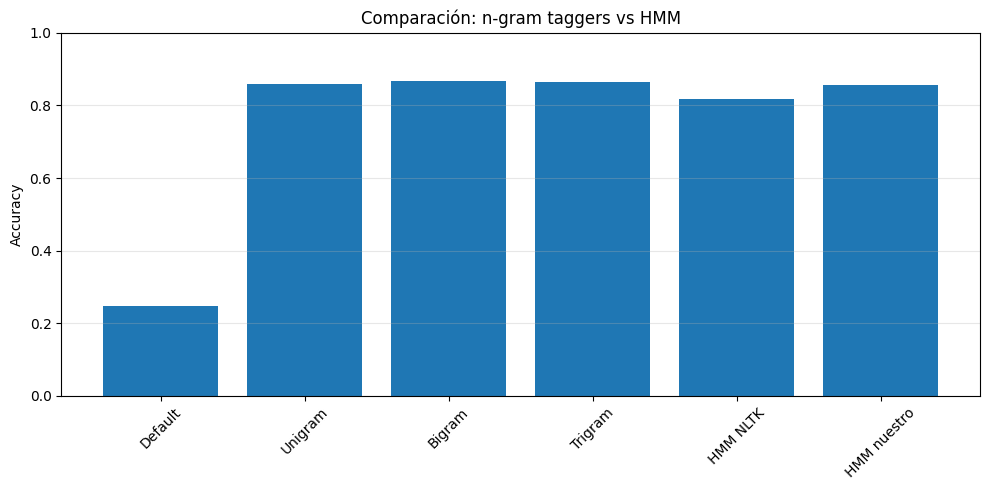

In [64]:
ngram_models = ["Default", "Unigram", "Bigram", "Trigram", "HMM NLTK", "HMM nuestro"]
ngram_acc = [
    default_eu.accuracy(test),
    uni_eu.accuracy(test),
    bi_eu.accuracy(test),
    tri_eu.accuracy(test),
    acc_test_nltk_eu,
    acc_test_ours_eu
]

plt.figure(figsize=(10,5))
plt.bar(ngram_models, ngram_acc)
plt.ylabel("Accuracy")
plt.title("Comparación: n-gram taggers vs HMM")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "ngram_vs_hmm.png", dpi=300, bbox_inches="tight")
plt.show()


Distribucion de errores por tag

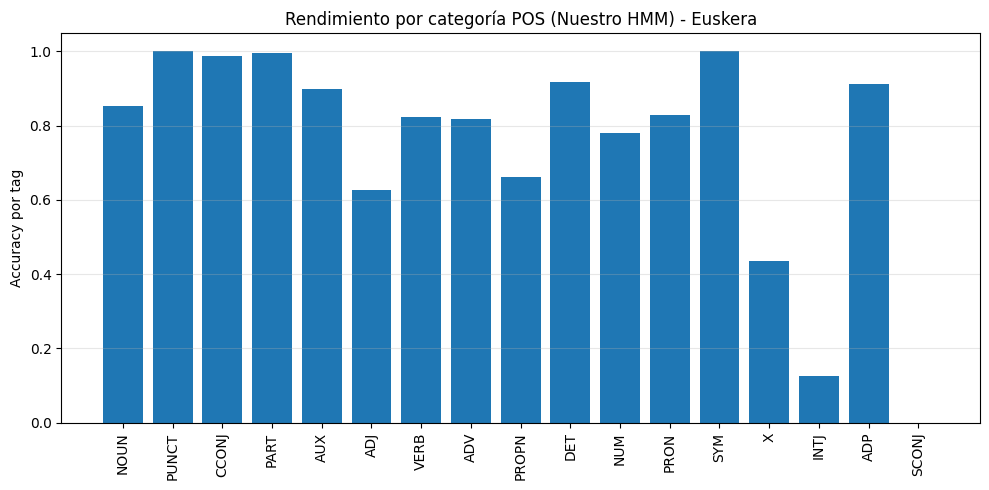

In [65]:
tag_acc_eu = per_tag_accuracy(hmm_eu, test_sentences, test_tags)

plt.figure(figsize=(10,5))
plt.bar(tag_acc_eu.keys(), tag_acc_eu.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy por tag")
plt.title("Rendimiento por categoría POS (Nuestro HMM) - Euskera")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "pos_accuracy_eu.png", dpi=300, bbox_inches="tight")
plt.show()


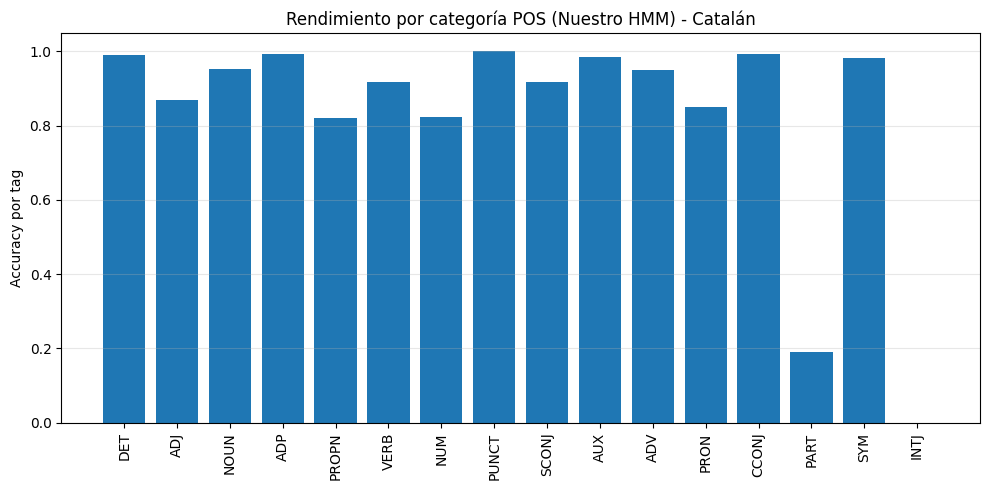

In [66]:
tag_acc_ca = per_tag_accuracy(hmm_ca, test_sentences_ca, test_tags_ca)

plt.figure(figsize=(10,5))
plt.bar(tag_acc_ca.keys(), tag_acc_ca.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy por tag")
plt.title("Rendimiento por categoría POS (Nuestro HMM) - Catalán")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "pos_accuracy_ca.png", dpi=300, bbox_inches="tight")
plt.show()
